In [1]:
import numpy as np

from congrad.numpy import cg_batch

In [2]:
N = 100
X = np.random.rand(N, N)
def A(b):
    return X @ X.T @ b + 0.001 * b
b = np.random.rand(N, 1)

# Monitors

Some solves are instantaneous.  For everything else, there's monitors.  You can turn monitoring on or off with a boolean parameter.

In [3]:
solution, info = cg_batch(A, b)

In [4]:
solution_monitor, info_monitor = cg_batch(A, b, monitor=True)

020: 2.02487e+00 (1.64318e-03 seconds)
040: 6.44958e-01 (3.28445e-03 seconds)
060: 4.17387e-01 (4.76503e-03 seconds)
080: 5.10093e-01 (6.29354e-03 seconds)
100: 3.40953e-01 (8.62670e-03 seconds)
120: 4.41120e-01 (1.02453e-02 seconds)
140: 4.10902e-01 (1.17543e-02 seconds)
160: 2.19412e-01 (1.32535e-02 seconds)
Finished in 1.38412e-02 seconds after 167 iterations (1.20655e+04 iterations/second) with a maximum residual of 4.44947e-03.


In [5]:
np.linalg.norm(solution - solution_monitor)

np.float64(0.0)

The default monitor prints every 20 iterations.  To choose a different interval, you can create a new instance of the `DefaultMonitor` class.

In [6]:
from congrad.monitoring import DefaultMonitor
solution, info = cg_batch(A, b, monitor=DefaultMonitor(30))

030: 1.15631e+00 (2.62570e-03 seconds)
060: 4.17387e-01 (4.36521e-03 seconds)
090: 2.60962e-01 (6.10805e-03 seconds)
120: 4.41120e-01 (7.73597e-03 seconds)
150: 4.31960e-02 (9.33599e-03 seconds)
Finished in 1.02465e-02 seconds after 167 iterations (1.62982e+04 iterations/second) with a maximum residual of 4.44947e-03.


PyConGrad also provides `ProgressBarMonitor` out of the box, which is powered by [tqdm](https://tqdm.github.io/).  It uses the `maxiter` parameter to determine the length of the progress bar it shows, so, with luck, it won't reach 100% before convergence.

In [7]:
from congrad.monitoring import ProgressBarMonitor
pbm = ProgressBarMonitor() # You can reuse monitor instances!  (Well-written ones, anyway.)
solution, info = cg_batch(A, b, monitor=pbm)
solution, info = cg_batch(A, b, maxiter=info["niter"] + 1, monitor=pbm)
solution, info = cg_batch(A, b, maxiter=None, monitor=pbm)

100%|██████████████████████████████████████| 168/168 [00:00<00:00, 19576.14it/s]
168it [00:00, 17995.79it/s]


# Custom Monitors

Monitors are good for more than printing status.  If you want to change the preconditioner halfway through your solve, a monitor can do that.  If you want to store intermediate solutions in an offsite backup, a monitor can do that.  Here, we collect residual norms throughout the solve and then plot them at the end to show convergence.

We use the NumPy backend but this works just as well with PyTorch.

In [8]:
import matplotlib.pyplot as plt

from congrad.monitoring import Monitor

In [9]:
class PlotMonitor(Monitor):
    def setup(self, stop_at, maxiter): # IMPORTANT: Do all initialization in setup rather than in __init__.
                                       # The former is called once per solve; the latter is called once overall.
        # stop_at: the maximum absolute error (calculated as max(|b| * rtol, atol) acceptable
        # maxiter: the maximum number of iterations allowable in this particular solve
        self.residuals = []

    def step(self, iteration, res_norm, x, is_end):
        # iteration: which iteration this is
        # res_norm: the current residual norm, as processed by the backend's presentable_norm function
        # x: the current candidate solution
        # is_end: True if, for some reason (convergence or iteration bound), this is the last iteration; False otherwise.
        self.residuals.append(res_norm)
        if is_end:
            plt.loglog(self.residuals)
            plt.show()

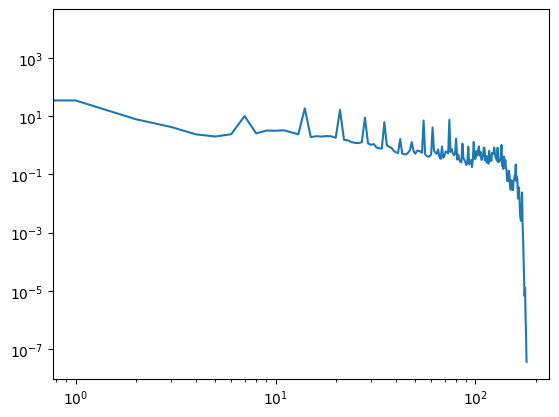

In [10]:
_solve, _info = cg_batch(A, b, rtol=1e-8, monitor=PlotMonitor())